In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from dynamics import *
from model import *

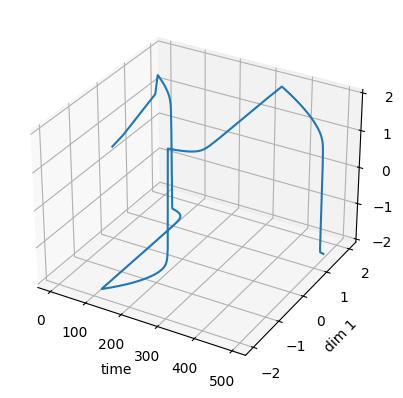

In [2]:
data = vdp_oscillator(dim=2, mu=25)

plot_3d(data.cpu().numpy())

In [17]:
def loss_fn(model, batch, num_negative_samples):
    min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    '''
    negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    '''
    negative_losses = []
    num_samples_per_batch = []
    for i in range(batch.shape[0]-1):
        num_samples = min(i, num_negative_samples)

        num_samples_per_batch.append(num_samples if num_samples else 1)

        if num_samples:
            # E_x_tp1_negative - E_x_t
            max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
            negative_loss = torch.sum(
                torch.maximum(torch.zeros_like(max_difference).cuda(), -max_difference)**2 + \
                torch.minimum(torch.zeros_like(max_difference).cuda(), -max_difference/10)
            )

            negative_losses.append(negative_loss)

    '''
    positive term loss
    '''
    # E_x_tp1_positive - E_x_t
    positive_loss = 50 * torch.Tensor(num_samples_per_batch).cuda() * \
                    torch.maximum(torch.zeros_like(min_difference).cuda(), min_difference)**2

    return torch.mean(positive_loss) + sum(negative_losses)/len(negative_losses)

    '''
    different way to generate negative samples:
        create a hypersphere of radius || E_x_tp1 - E_x_t ||
        pick vectors in that hypersphere that are `angle` away from vector E_x_tp1 - E_x_t
    '''
    # for i in range(batch.shape[0]-1):
    #     E_x_t = model(batch[i, :].unsqueeze(0)).repeat(num_negative_samples)
    #     E_x_tp1 = model(generate_negative_samples(batch[i, :], angle=45, num_samples=num_negative_samples))
    
    #     difference = E_x_tp1 - E_x_t
    #     difference[difference.abs() > 5e-4] = difference
    
    #     loss = torch.sum(torch.maximum(torch.zeros(num_negative_samples).cuda(), margin - (difference))**2)
    #     # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (difference))))
    #     # loss = torch.sum(torch.exp(-(difference)))

    #     losses.append(loss)


def plot_energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)
    plt.title("energy along trajectory")

    plt.show()


def plot_energy_landscape(model):
    X = torch.linspace(-10, 10, steps=500)
    Y = torch.linspace(-10, 10, steps=500)

    energy_manifold = model(torch.cartesian_prod(X, Y).cuda()).reshape(X.shape[0], Y.shape[0]).detach().cpu().numpy()

    X, Y = np.meshgrid(X.numpy(), Y.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, energy_manifold, cmap='viridis', edgecolor='k', linewidth=0.5, facecolor=(1,1,1,0.2))

    fig.colorbar(surface, pad=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$energy$')
    ax.set_title('energy landscape')
    
    plt.show()


def epoch(iterations, model, optimizer, data, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(data, bs=bs)

        optimizer.zero_grad()

        loss = loss_fn(model, batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

  1%|          | 1/100 [00:02<03:20,  2.03s/it]

-0.24510834142565727


  2%|▏         | 2/100 [00:04<03:17,  2.01s/it]

-0.5616244196891784


  3%|▎         | 3/100 [00:06<03:14,  2.01s/it]

-1.0289312601089478


  4%|▍         | 4/100 [00:08<03:12,  2.00s/it]

0.87069753408432


  5%|▌         | 5/100 [00:10<03:11,  2.02s/it]

-0.10054705142974854


  6%|▌         | 6/100 [00:12<03:08,  2.01s/it]

-0.9425819158554077


  7%|▋         | 7/100 [00:14<03:06,  2.00s/it]

0.07519326210021973


  8%|▊         | 8/100 [00:16<03:03,  1.99s/it]

-1.337072765827179


  9%|▉         | 9/100 [00:18<03:01,  1.99s/it]

-1.4265071630477906


 10%|█         | 10/100 [00:20<02:59,  1.99s/it]

-1.275066512823105


 11%|█         | 11/100 [00:21<02:57,  1.99s/it]

3.325444054603577


 12%|█▏        | 12/100 [00:24<02:56,  2.00s/it]

-1.4537666201591493


 13%|█▎        | 13/100 [00:26<02:53,  2.00s/it]

-1.1199658632278442


 14%|█▍        | 14/100 [00:27<02:51,  1.99s/it]

-0.6089298009872437


 15%|█▌        | 15/100 [00:29<02:49,  1.99s/it]

-0.3549647361040115


 16%|█▌        | 16/100 [00:31<02:47,  1.99s/it]

-1.4204332828521729


 17%|█▋        | 17/100 [00:33<02:45,  1.99s/it]

-0.10813554972410203


 18%|█▊        | 18/100 [00:35<02:43,  1.99s/it]

-0.9533176422119141


 19%|█▉        | 19/100 [00:37<02:41,  1.99s/it]

0.2198577642440796


 20%|██        | 20/100 [00:39<02:39,  1.99s/it]

-1.3591681599617005


 21%|██        | 21/100 [00:41<02:37,  1.99s/it]

-0.4032635450363159


 22%|██▏       | 22/100 [00:43<02:35,  1.99s/it]

0.2728617608547211


 23%|██▎       | 23/100 [00:45<02:33,  1.99s/it]

-0.8395892143249511


 24%|██▍       | 24/100 [00:47<02:31,  2.00s/it]

-1.1893265008926392


 25%|██▌       | 25/100 [00:49<02:29,  2.00s/it]

-0.9411367654800415


 26%|██▌       | 26/100 [00:51<02:27,  2.00s/it]

-1.0018699407577514


 27%|██▋       | 27/100 [00:53<02:25,  2.00s/it]

-1.5096217185258864


 28%|██▊       | 28/100 [00:55<02:23,  2.00s/it]

-0.5659083604812623


 29%|██▉       | 29/100 [00:57<02:21,  1.99s/it]

1.1771925926208495


 30%|███       | 30/100 [00:59<02:19,  1.99s/it]

-0.6667922139167786


 31%|███       | 31/100 [01:01<02:17,  1.99s/it]

-0.16578221917152405


 32%|███▏      | 32/100 [01:03<02:15,  1.99s/it]

0.19716033935546876


 33%|███▎      | 33/100 [01:05<02:13,  1.99s/it]

0.5935509204864502


 34%|███▍      | 34/100 [01:07<02:11,  1.99s/it]

-0.4666572824120522


 35%|███▌      | 35/100 [01:09<02:09,  1.99s/it]

-0.5000520706176758


 36%|███▌      | 36/100 [01:11<02:07,  1.99s/it]

-0.487334156036377


 37%|███▋      | 37/100 [01:13<02:05,  1.99s/it]

-0.4224532231688499


 38%|███▊      | 38/100 [01:15<02:03,  1.99s/it]

-0.5501934051513672


 39%|███▉      | 39/100 [01:17<02:01,  1.99s/it]

0.19650381058454514


 40%|████      | 40/100 [01:19<01:59,  1.99s/it]

-0.3738890290260315


 41%|████      | 41/100 [01:21<01:57,  1.99s/it]

-0.08419858831912279


 42%|████▏     | 42/100 [01:23<01:55,  1.99s/it]

-0.6281680271029473


 43%|████▎     | 43/100 [01:25<01:53,  1.99s/it]

-0.4804652199149132


 44%|████▍     | 44/100 [01:27<01:51,  1.99s/it]

-0.2737575531005859


 45%|████▌     | 45/100 [01:29<01:49,  1.99s/it]

-0.7461111605167389


 46%|████▌     | 46/100 [01:31<01:47,  1.99s/it]

-0.6271559774875641


 47%|████▋     | 47/100 [01:33<01:45,  1.99s/it]

-0.7977546319365502


 48%|████▊     | 48/100 [01:35<01:43,  1.99s/it]

-1.1167625844478608


 49%|████▉     | 49/100 [01:37<01:41,  1.99s/it]

-0.4688239455223083


 50%|█████     | 50/100 [01:39<01:40,  2.01s/it]

-1.5487169742584228


 51%|█████     | 51/100 [01:41<01:38,  2.00s/it]

-0.8806513249874115


 52%|█████▏    | 52/100 [01:43<01:36,  2.00s/it]

0.26426455974578855


 53%|█████▎    | 53/100 [01:45<01:33,  2.00s/it]

-1.2201018333435059


 54%|█████▍    | 54/100 [01:47<01:32,  2.00s/it]

-1.9895696878433227


 55%|█████▌    | 55/100 [01:49<01:29,  2.00s/it]

-1.9899553298950194


 56%|█████▌    | 56/100 [01:51<01:27,  2.00s/it]

4.549782800674438


 57%|█████▋    | 57/100 [01:53<01:25,  2.00s/it]

-1.0995405435562133


 58%|█████▊    | 58/100 [01:55<01:23,  1.99s/it]

-0.03812638521194458


 59%|█████▉    | 59/100 [01:57<01:21,  1.99s/it]

-0.4502382516860962


 60%|██████    | 60/100 [01:59<01:19,  2.00s/it]

-1.0629205703735352


 61%|██████    | 61/100 [02:01<01:17,  2.00s/it]

-0.708389288187027


 62%|██████▏   | 62/100 [02:03<01:15,  2.00s/it]

-0.0712039589881897


 63%|██████▎   | 63/100 [02:05<01:13,  2.00s/it]

-0.6016331434249877


 64%|██████▍   | 64/100 [02:07<01:12,  2.01s/it]

0.1061104416847229


 65%|██████▌   | 65/100 [02:09<01:10,  2.02s/it]

-0.3628982901573181


 66%|██████▌   | 66/100 [02:11<01:08,  2.01s/it]

-0.8191280633211135


 67%|██████▋   | 67/100 [02:13<01:06,  2.01s/it]

-0.7827802419662475


 68%|██████▊   | 68/100 [02:15<01:04,  2.00s/it]

-0.9490476787090302


 69%|██████▉   | 69/100 [02:17<01:02,  2.01s/it]

-0.5358263850212097


 70%|███████   | 70/100 [02:19<01:00,  2.02s/it]

-0.3642381191253662


 71%|███████   | 71/100 [02:21<00:58,  2.01s/it]

-1.1124089717864991


 72%|███████▏  | 72/100 [02:23<00:56,  2.01s/it]

-1.4752460718154907


 73%|███████▎  | 73/100 [02:25<00:54,  2.00s/it]

-0.931504237651825


 74%|███████▍  | 74/100 [02:27<00:52,  2.00s/it]

-1.4074092984199524


 75%|███████▌  | 75/100 [02:29<00:49,  2.00s/it]

-1.5487015783786773


 76%|███████▌  | 76/100 [02:31<00:47,  2.00s/it]

0.21669660806655883


 77%|███████▋  | 77/100 [02:33<00:45,  2.00s/it]

-0.22004303932189942


 78%|███████▊  | 78/100 [02:35<00:43,  1.99s/it]

-1.448742151260376


 79%|███████▉  | 79/100 [02:37<00:41,  1.99s/it]

2.0941548109054566


 80%|████████  | 80/100 [02:39<00:39,  1.99s/it]

1.3677058696746827


 81%|████████  | 81/100 [02:41<00:37,  1.99s/it]

-0.1823523759841919


 82%|████████▏ | 82/100 [02:43<00:35,  1.99s/it]

-0.44229369759559634


 83%|████████▎ | 83/100 [02:45<00:34,  2.01s/it]

-0.5043247938156128


 84%|████████▍ | 84/100 [02:47<00:32,  2.00s/it]

-0.3214514821767807


 85%|████████▌ | 85/100 [02:49<00:30,  2.00s/it]

-0.4893035635352135


 86%|████████▌ | 86/100 [02:51<00:28,  2.00s/it]

0.07069886177778244


 87%|████████▋ | 87/100 [02:53<00:25,  2.00s/it]

-0.3833369851112366


 88%|████████▊ | 88/100 [02:55<00:23,  2.00s/it]

-0.20861549824476242


 89%|████████▉ | 89/100 [02:57<00:21,  1.99s/it]

-0.37224399745464326


 90%|█████████ | 90/100 [02:59<00:19,  1.99s/it]

-0.1152499258518219


 91%|█████████ | 91/100 [03:01<00:17,  1.99s/it]

-0.3755105406045914


 92%|█████████▏| 92/100 [03:03<00:15,  1.99s/it]

-0.49350973069667814


 93%|█████████▎| 93/100 [03:05<00:14,  2.00s/it]

-0.6018281936645508


 94%|█████████▍| 94/100 [03:07<00:12,  2.00s/it]

-0.6543533593416214


 95%|█████████▌| 95/100 [03:09<00:09,  2.00s/it]

-0.5026770800352096


 96%|█████████▌| 96/100 [03:11<00:07,  2.00s/it]

-0.49404085576534273


 97%|█████████▋| 97/100 [03:13<00:05,  2.00s/it]

-0.619471526145935


 98%|█████████▊| 98/100 [03:15<00:03,  1.99s/it]

0.400149405002594


 99%|█████████▉| 99/100 [03:17<00:01,  1.99s/it]

-1.0448446810245513


100%|██████████| 100/100 [03:19<00:00,  2.00s/it]

0.522418101131916


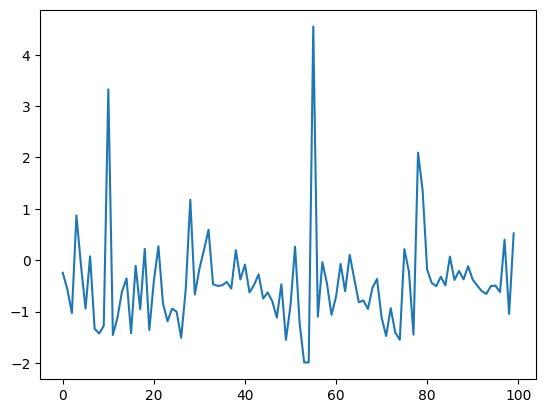

In [18]:
dim = 2

model = EBM(2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

losses = []

for e in tqdm(range(100)):
    data = vdp_oscillator(dim=dim, mu=25)

    N = data.shape[0]
    bs = int(0.5 * N)

    loss = epoch(iterations=5, model=model, optimizer=optimizer, data=data, bs=bs, num_negative_samples=int(bs * 0.5))
    losses.append(loss)
    print(loss)

plt.plot(losses)

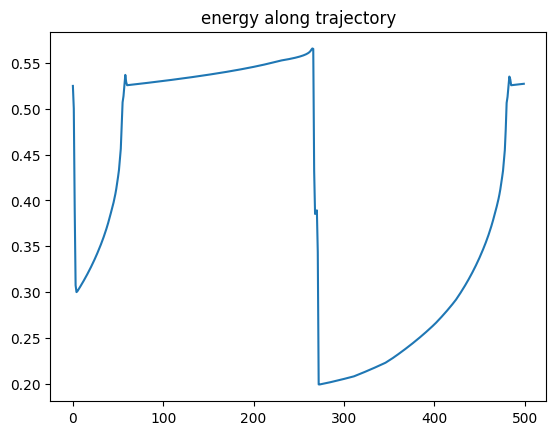

In [25]:
plot_energy_along_trajectory(model, vdp_oscillator(dim=dim, mu=25))

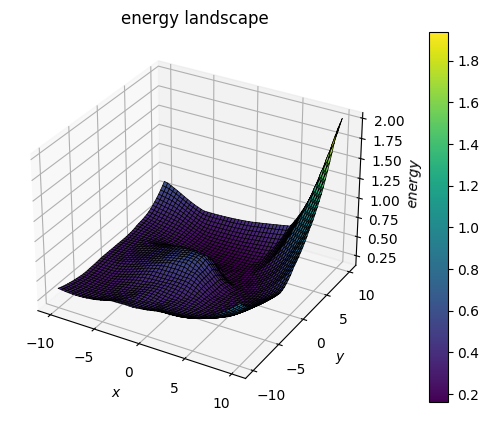

In [21]:
plot_energy_landscape(model)